# 0. Introduction

Distributions of shortest path lengths measure connectivity and geography in urban networks. In this analysis, we investigate the following questions: 

## 0.1 Questions

**Single-layer effects:**

1. How do shortest path distributions in Riyadh depend on the edge weights used? 
2. To what extent do shortest path distributions share a universal shape? 
3. How does the introduction of realistic OD-demand data change shortest path distributions? 
4. How are shortest path lengths (i.e. commuting times) distributed around the city? 

**Multi-layer effects:**

5. How does the introduction of a metro system impact shortest path distributions under uniform and OD demand? 
6. How many travelers have shortest paths that involve the metro? (this is 'intermodality' as defined in Strano et al.)
7. How are both of the answers above impacted by increasing metro speeds? 

## 0.2 Summary of findings

** Single layer**

1. Under uniform demand, shortest path distributions are sensitive to edge weights only in **location** and **scale**; however, their underlying **shape** is largely invariant. 
2. Under OD demand, the picture is substantially different: shortest path distributions under different edge weights differ in shape, as well as scale and location. 
3. As expected, long commuting times are primarily observed for origins and destinations on the city periphery. We also observe large commuting flows into the city center, as well as smaller pockets of people who work in the same areas in which they live. 

** Multi-layer**

1. Under uniform demand and congested edge weights, the introduction of the metro does not substantially change shortest path distributions at 'base' ($\beta = 1$) speeds. Increasing the speed, however, we find that the introduction of a fast metro changes the shape of shortest path distributions; this finding differs from that in Strano et al. 
2. Using weighted OD demand, we find that the introduction of a fast metro also substantially changes shape of shortest path distributions. We also observe the existence of a limiting distribution for very small $\beta$. Intriguingly, this distribution is similar to that observed in the uniform demand case. 
3. Finally, we observe an increase in intermodality (the proportion of shortest paths that pass through the metro) as $\beta$ decreases. At $\beta = 1$, approximately 20% of shortest paths are intermodal; this increases asymptotically to approximately 60% as $\beta$ increases. This suggests that, for roughly 40% of the population, it would take them longer to walk to and from the metro stations than it would take to drive directly, regardless of metro speed. 

## 0.3 Assumptions

- All computations involving edge weights on the street use congested travel time (in minutes) as determined through ITA, unless explicitly noted otherwise. 
- All computations involving edge weights on the metro network use free-flow travel time. The metro network is uncapacitated. 
- No waiting times are modeled from street to metro or back: agents pick up the metro as soon as they arrive. 

In [1]:
% matplotlib inline

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import warnings 
import itertools
import math

In [2]:
warnings.filterwarnings('ignore') # don't display warnings when executing commands
sns.set_style("white") # nicer plots

In [3]:
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

In [4]:
# Certain analyses in this worksheet are very processor intensive. 
# You have the option of only running them on a subset of the nodes in the graph. 
# To do this, set a value for `n_nodes` below. 
# To run full computations, choose `n_nodes = None`.
n_nodes = None

# 1. Single-layer effects: universality and OD demand 

First, we study the shortest path distributions on the single street layer. We will find universality in distributions under uniform demand, and see that universality broken under OD demand. We'll also observe the spatial distribution travel demand and of OD trip lengths. 

## 1.1 Universality of shortest paths under uniform demand

Let's start with a uniform demand assumption, in which there is one unit of travel demand from every node to every other node in the network. Our variable will be edge-weights. We will consider: 

1. **Uniform edge weights**, in which every street has a 'speed limit' equal to the average speed on the network. This corresponds to Strano et al.'s assumptions. 
2. **Free flow edge weights**, in which every street has a speed limit modeled from OSM data on the street type and Serdar's OSM converter script. Models 'real driving' without any traffic. 
3. **Congested edge weights**, in which every street has speed reduced according to an ITA congestion calculation. Models 'real driving' with traffic.

Below, we plot the distributions under each edge weight. The 'raw' distributions are on the left. On the right, we show the standardized distributions. 

In [5]:
# To speed up computations, we'll primarily work in igraph throughout this section. 

g = utility.nx_2_igraph(multi.layers_as_subgraph(['streets'])) # get the street layer and convert it to igraph
weights = ['congested_time_m', 'free_flow_time_m', 'uniform_time_m'] # define weights we'll use
nodes = np.array([v.index for v in g.vs if g.vs[v.index]['layer'] == 'streets']) # nodes on which to compute
if n_nodes: # optional sampling
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

In [6]:
# Now we'll compute shortest paths under each of the edge weights and collect them 
# into a dataframe for easy visualization. 

# main computation
d = {weight : analysis.path_lengths_igraph(g, nodes, weight, mode = 'array') for weight in weights}

# collect into df
uniform_demand = pd.DataFrame(d)

# reorder the columns (just for aesthetics)
uniform_demand = uniform_demand[weights]

# filter out paths between unreachable nodes
for weight in weights:
    uniform_demand = uniform_demand[uniform_demand[weight] != np.inf]

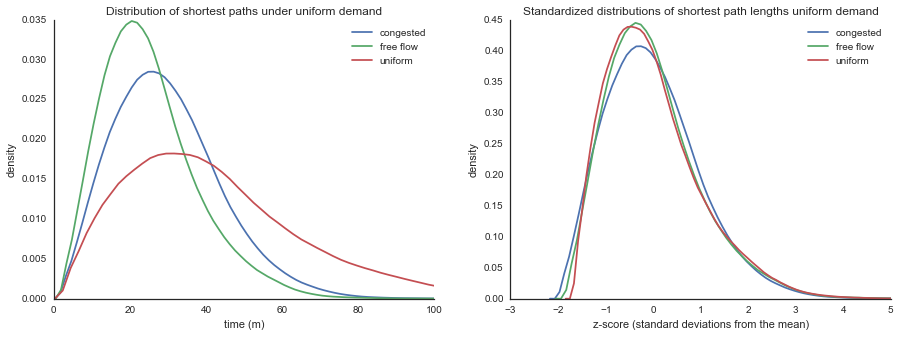

In [7]:
# Time to visualize! 
fig = plt.figure(figsize = (15, 5))

# Regular distributions
ax = fig.add_subplot(121)

sns.distplot(uniform_demand['congested_time_m'], kde = True, hist = False, label = 'congested')
sns.distplot(uniform_demand['free_flow_time_m'], kde = True, hist = False, label = 'free flow')
sns.distplot(uniform_demand['uniform_time_m'], kde = True, hist = False, label = 'uniform')

ax.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density')
sns.despine()

plt.title('Distribution of shortest paths under uniform demand')

# standardized distributions
ax = fig.add_subplot(122)

sns.distplot(analysis.standardize(uniform_demand['congested_time_m']), kde = True, hist = False, label = 'congested')
sns.distplot(analysis.standardize(uniform_demand['free_flow_time_m']), kde = True, hist = False, label = 'free flow')
sns.distplot(analysis.standardize(uniform_demand['uniform_time_m']), kde = True, hist = False, label = 'uniform')

ax.set(xlim = (-3, 5), xlabel = 'z-score (standard deviations from the mean)', ylabel = 'density')
sns.despine()

plt.title('Standardized distributions of shortest path lengths uniform demand')
plt.savefig('4_figs/shortest_paths/dists_uniform.png')

### Observations

**Left plot**

1. **Uniform time** leads to the slowest paths, because travellers cannot use highways or other high-speed-limit roads to speed up their journeys. 
2. In contrast, **free flow time** weighting encourages travellers to use high-speed-limit throughways as much as convenient. 
3. Finally, **congested time** weighting is something of a compromise -- like free flow, there is benefit to using high-speed-limit roads, but the benefits are decreased due to the popularity -- and therefore congestion -- of those roads. 

** Right plot**

1. After standardizing the distributions, we find that they have substantially the same shape, in line with Strano et al. 
2. The common distribution could be either lognormal, Rayleigh, or $\Gamma$/Erlang. At this stage, I am not sure how to pick among these. 
3. Suggestively, the standardized congested distribution is somewhat different from the free flow and uniform distributions, which are quite close to each other. This is our first hint that actual network usage data may significantly change the picture. 

### Summary Statistics

In [8]:
np.round(uniform_demand.describe(),1)

,congested_time_m,free_flow_time_m,uniform_time_m
count,114993462.0,114993462.0,114993462.0
mean,29.8,25.2,42.3
std,14.3,12.8,24.1
min,0.0,0.0,0.0
25%,19.4,16.0,24.5
50%,28.4,23.3,38.4
75%,38.5,32.2,55.6
max,180.8,179.7,261.8


## 1.2 Impact of OD demand

We now consider the same distributions weighted by OD demand. Below, we plot the distribution of shortest path lengths under OD-demand for congested, free flow, and uniform edge weights. For comparison, we also include the distributions under uniform demand we observed above. 

In [9]:
# need to pull g again with taz nodes 
g = utility.nx_2_igraph(multi.layers_as_subgraph(['streets', 'taz']))

# need to read in od data as a df
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False)

In [10]:
# First, we'll create a 'base' dataframe to hold our results. 
# Each row corresponds to an OD pair

# set up the base and convert to df
nodes = np.array([v.index for v in g.vs if v['layer'] == 'taz'])
indices = [(x,y) for (x,y) in itertools.product(range(len(nodes)), repeat=2)]
o_i = [x for (x,y) in indices]
d_i = [y for (x,y) in indices]
od_demand = pd.DataFrame({'o_i':o_i, 'd_i':d_i})

# add igraph keys to df
od_demand['o'] = od_demand['o_i'].map(lambda o_i : nodes[o_i]) # igraph keys
od_demand['d'] = od_demand['d_i'].map(lambda d_i : nodes[d_i]) # igraph keys

# add nx keys to df
name_lookup = {v.index : g.vs[v.index]['name'] for v in g.vs} # lookup to get nx labels
od_demand['o_nx'] = od_demand['o'].map(name_lookup.get) # nx keys for later
od_demand['d_nx'] = od_demand['d'].map(name_lookup.get) # nx keys for later

# add od data to base df
od_demand = od_demand.merge(od)

In [11]:
# Now we're ready to compute shortest paths and merge them into the data frame. 
for weight in weights:
    p = analysis.path_lengths_igraph(g, nodes, weight, mode = 'list')
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]
    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, weight : p})
    od_demand = od_demand.merge(lengths)

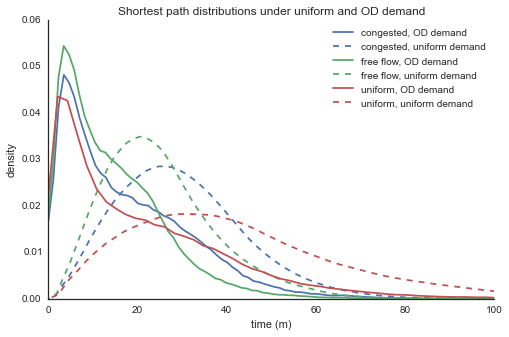

In [12]:
# Ready to visualize. 

# Utility plot for plotting histograms weighted by OD demand
def OD_weighted_hist(df, measure, label, **kwargs):
    n = 100
    hist = np.histogram(df[measure], weights = df['flow_norm'], normed = True, bins = n)
    x = hist[1][:n] 
    y = hist[0]
    plt.plot(x,y, label = label, **kwargs)

# make the plot
fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

current_palette = sns.color_palette()

OD_weighted_hist(od_demand, 'congested_time_m', label = 'congested, OD demand', color = current_palette[0])
sns.kdeplot(uniform_demand['congested_time_m'], label = 'congested, uniform demand', ls = '--', color = current_palette[0])
OD_weighted_hist(od_demand, 'free_flow_time_m', label = 'free flow, OD demand', color = current_palette[1])
sns.kdeplot(uniform_demand['free_flow_time_m'], label = 'free flow, uniform demand', ls = '--', color = current_palette[1])
OD_weighted_hist(od_demand, 'uniform_time_m', label = 'uniform, OD demand', color = current_palette[2])
sns.kdeplot(uniform_demand['uniform_time_m'], label = 'uniform, uniform demand', ls = '--', color = current_palette[2])

ax.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density')
sns.despine()
plt.legend()
plt.title('Shortest path distributions under uniform and OD demand')
plt.savefig('4_figs/shortest_paths/dists_od.png')

### Observations

1. The distributions have shifted far to the left, possibly reflecting a preference to live closer to work. 
2. I do not know of any parametric distributions that would well-model any of the OD-weighted distributions. 
2. Each of the OD-weighted distributions has a qualitatively different shape from the others -- no universality here. 

For reference, we compute the weighted average shortest path lengths below. This estimate the mean travel time experienced by a traveler on the street network. 

In [13]:
for weight in weights:
    print weight + ' -- ' + str(round(np.average(od_demand[weight], weights = od_demand['flow_norm']),2))

congested_time_m -- 18.29
free_flow_time_m -- 15.03
uniform_time_m -- 22.09


## 1.3 Spatial distribution of demand and trip lengths 

We now turn to the spatial distribution of travel times. In this section, we'll visualize the distribution of travel demand and mean travel time around the city. As a warmup, we plot the spatial distribution of origin and destination demand. Warmer colors indicate higher demand at that node. Only demand on TAZ nodes is plotted. 

In [14]:
# Utility function for computing weighted averages by group. The input is a df.groupby() object. 
def wavg(group):
    d = group['congested_time_m']
    w = group['flow_norm']
    return (d * w).sum() / w.sum()

# compute weighted averages and total population by origin
grouped_o = od_demand[od_demand['flow_norm'] > 0].groupby('o_nx')
o_time = grouped_o.apply(wavg)
o = grouped_o.sum()['flow_norm']

# compute weighted averages and total population by destination
grouped_d = od_demand[od_demand['flow_norm'] > 0].groupby('d_nx')
d_time = grouped_d.apply(wavg)
d = grouped_d.sum()['flow_norm']

# transform each computed measure into a dict; df.to_dict() is a convenient way to do this. 
df = pd.DataFrame({'o' : o, 'o_time' : o_time, 'd' : d, 'd_time' : d_time})
dicts = df.to_dict()

# add computed measures to multi.G
for name in ['o', 'o_time', 'd', 'd_time']:
    nx.set_node_attributes(multi.G, name, 0)
    nx.set_node_attributes(multi.G, name, dicts[name])

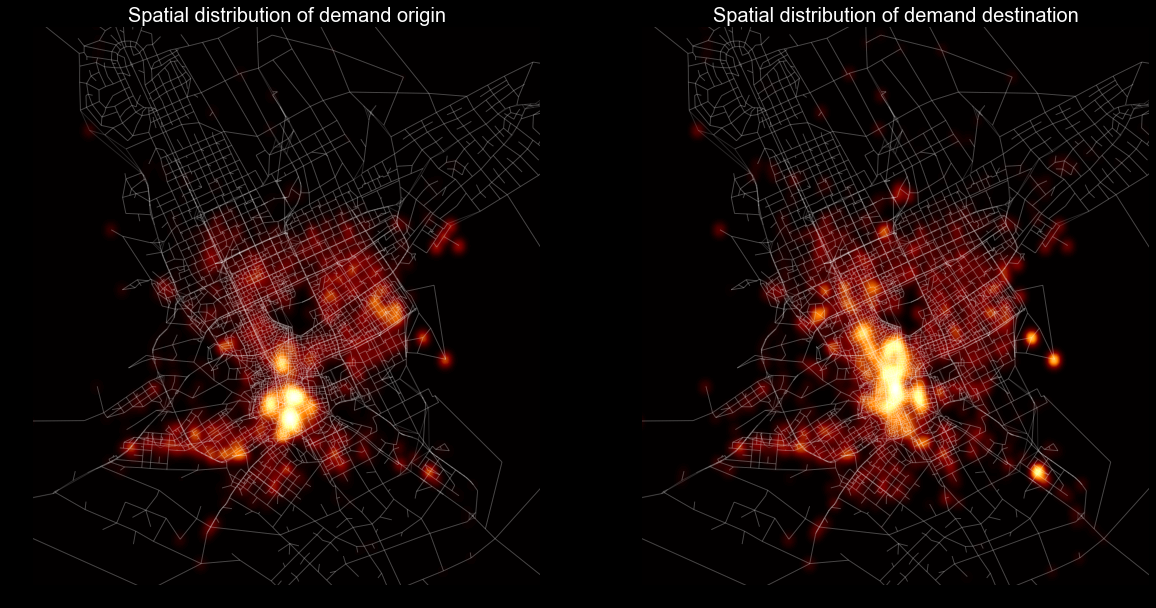

In [15]:
# visualization time! 
fig = plt.figure(figsize = (2*10,10))
xlim = (46.4167, 47.0167)
ylim = (24.4333, 25.0333)

# spatial plot of origin travel demand
ax = fig.add_subplot(121)
viz.spatial_plot(multi.G, 
                 attr = 'o', 
                 ax = ax, 
                 layer = 'taz')

ax.set(xlim = xlim, ylim = ylim)
plt.title('Spatial distribution of demand origin', 
              color = 'w', 
              fontsize = 20)

# spatial plot of destination travel demand
ax = fig.add_subplot(122)
viz.spatial_plot(multi.G, 
                 attr = 'd', 
                 ax = ax, 
                 layer = 'taz')

ax.set(xlim = xlim, ylim = ylim)
plt.title('Spatial distribution of demand destination', 
              color = 'w', 
              fontsize = 20)

fig.set_facecolor("#000000")
plt.savefig('4_figs/shortest_paths/spatial_demand.png', facecolor=fig.get_facecolor(),  edgecolor='none')

### Observations

1. Both origin and destination travel demand are fairly tightly clustered in the center of the city. 
2. A few nodes on the outskirts have low origin demand but high destination demand, suggesting e.g. office parks, factories, or other areas with job opportunities and low residential desirability. 
3. There is a patch toward the middle-right with high origin demand, suggesting a residential zone. 

We can also ask how trip length is distributed spatially. In the below visualization, the size of a bubble corresponds to its travel demand, and its color to mean trip length; warmer colors reflect longer trips. On the left we group by origin; this plot can be interpreted as the average travel time by residence. On the right we group by destination; this plot can be interpreted as the average travel time by place of work.

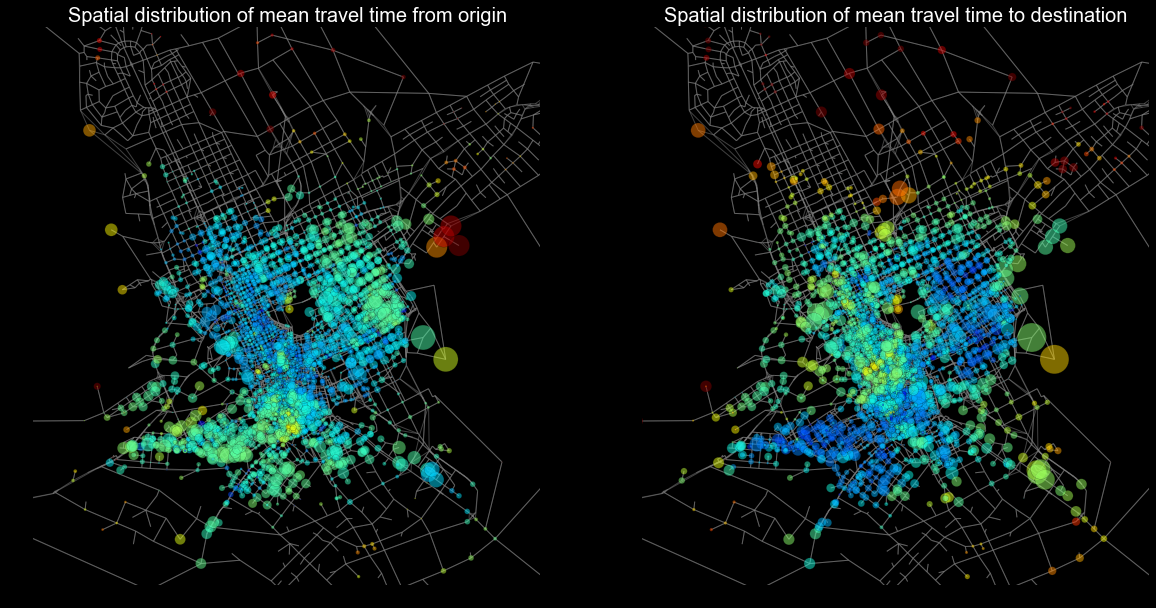

In [16]:
# Visualization time! 

G = multi.G # pull G for plotting functions

# create the figure
fig = plt.figure(figsize = (2*10,10))

# bubble plot by origin
ax = fig.add_subplot(121)
viz.bubble_plot(G, size = 'o', color = 'o_time', size_factor = 0.05, vmax = 45, cmap = 'jet', alpha = .5)
plt.title('Spatial distribution of mean travel time from origin', 
              color = 'w', 
              fontsize = 20)

ax.set(xlim = xlim, ylim = ylim)

# bubble plot by destination
ax = fig.add_subplot(122)
viz.bubble_plot(G, size = 'd', color = 'd_time', size_factor = 0.05, vmax = 45, cmap = 'jet', alpha = .5)
plt.title('Spatial distribution of mean travel time to destination', 
              color = 'w', 
              fontsize = 20)
ax.set(xlim = xlim, ylim = ylim)

fig.set_facecolor("#000000")
plt.savefig('4_figs/shortest_paths/spatial_trip_length.png', facecolor=fig.get_facecolor(),  edgecolor='none')

### Observations

1. Predictably, red nodes with long travel times are scattered around the periphery of the city on both plots. 
2. We observe near the center of the plot a deep blue area with low residential demand. These may reflect a population that both lives and works downtown. 
3. We also observe neighborhoods to the south and west of downtown that have high residential demand and medium-length (green) trip lengths grouped by origin, but low destination demand and very short (deep blue) trip lengths grouped by destination. PC is inclined to interpret this as follows: while many live in these neighborhoods, there are not many jobs there, and most commute downtown. On the other hand, those who work int he area are likely to live there as well, leading to shorter commuting times. 

# 2. Multilayer Effects

Now we'll begin our analysis of the multilayer effects of the metro on shortest path distributions. 

In [17]:
# set betas
betas = [1000.0, 100.0, 10.0, 1.0, .9, .8, .7, .6, .5, .4, .3, .2, .1, .01, .001]

# for plotting, we'll need this many colors
sns.set_palette(sns.cubehelix_palette(n_colors = len(betas)))

# Re-pull g and get a fresh copy of the OD table (just in case)
g = utility.nx_2_igraph(multi.as_graph())
nodes = np.array([v.index for v in g.vs if g.vs[v.index]['layer'] == 'streets']) # nodes to compute demand from/to

if n_nodes: # optional node sampling
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt', pivot = False) # need to re-key since we are working with a different graph now

## 2.1 Shortest path distributions under uniform demand

First we'll aim reproduce the findings of Strano et. al, who found that the distribution of shortest paths under uniform demand was invariant (up to scale and location) under the metro scaling. On the left, we plot the distribution for decreasing values of $\beta$. On the right, we plot the same distribution, standardized. Both plots are executed with uniform edge weights, as in Strano et al.

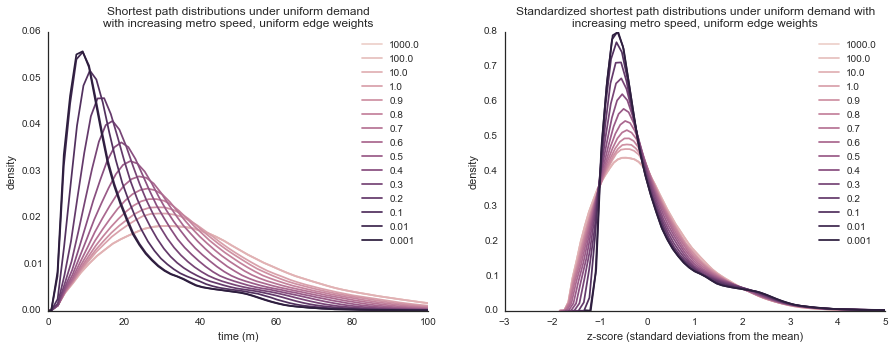

In [18]:
# create figure and subplots
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# loop through betas, scaling, computing shortest path lengths, and plotting
for beta in betas: 
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'uniform_time_m', beta = beta)
    lengths = analysis.path_lengths_igraph(g, nodes, 'uniform_time_m', mode = 'array')
    lengths = lengths[np.isinf(lengths) == False]
    sns.distplot(lengths, kde = True, hist = False, label = str(beta), ax = ax1)
    sns.distplot(analysis.standardize(lengths), kde = True, hist = False, label = str(beta), ax = ax2)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'uniform_time_m', beta = 1.0 / beta)

# labels and aesthetics
ax1.set(xlim = (0, 100), xlabel = 'time (m)', ylabel = 'density', title = 'Shortest path distributions under uniform demand \nwith increasing metro speed, uniform edge weights')
ax2.set(xlim = (-3, 5), xlabel = 'z-score (standard deviations from the mean)', ylabel = 'density', title = 'Standardized shortest path distributions under uniform demand with \nincreasing metro speed, uniform edge weights')
sns.despine()
plt.savefig('4_figs/shortest_paths/dists_uniform_metro.png')

### Observations

1. We do observe a certain degrees of universality in the standardized distributions; however, as $\beta$ decreases, we also find that the distributions become notably more concentrated around the mean.
2. Despite this, there appears to be a limiting distribution -- past a certain level, further reductions in $\beta$ make no material difference for shortest paths. 
3. This is likely because most routes require at least some travel on the street network, and this travel time cannot be reduced by decreasing $\beta$. At the high end, there are also some OD pairs for which it takes longer to drive to and from metro stations than it does to drive there directly, even under uniform edge weights. 

## 2.2 Shortest path distributions under OD demand

How does the picture change under OD demand? Below, we plot the shortest path distributions under OD demand and congested edge weights for varying $\beta$. 

In [19]:
# get taz nodes, optionally sample them, and construct a base OD for plotting
nodes = np.array([v.index for v in g.vs if v['layer'] == 'taz'])
if n_nodes:
    nodes = np.random.choice(nodes, size = n_nodes, replace = False) 

indices = [(x,y) for (x,y) in itertools.product(range(len(nodes)), repeat=2)]
o_i = [x for (x,y) in indices]
d_i = [y for (x,y) in indices]

od_demand = pd.DataFrame({'o_i':o_i, 'd_i':d_i})

od_demand['o'] = od_demand['o_i'].map(lambda o_i : nodes[o_i]) # igraph keys
od_demand['d'] = od_demand['d_i'].map(lambda d_i : nodes[d_i]) # igraph keys

od_demand = od_demand.merge(od)

In [20]:
# execute the analysis: compute the path lengths and merge into the od_demand table. 

for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = beta)
    p = analysis.path_lengths_igraph(g, nodes, 'congested_time_m', mode = 'list')
    q = [(nodes[i],nodes[j],p[i][j]) for i in range(len(nodes)) for j in range(len(nodes))]
    o = [tup[0] for tup in q]
    d = [tup[1] for tup in q]
    p = [tup[2] for tup in q]
    lengths = pd.DataFrame({'o' : o, 'd' : d, 'congested_time_' + str(beta) : p})
    od_demand = od_demand.merge(lengths)
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'congested_time_m', beta = 1.0 / beta)

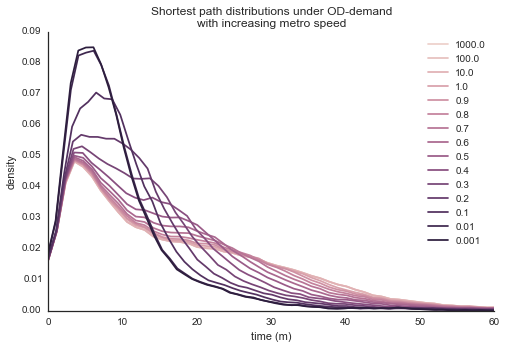

In [21]:
# time to plot!

fig = plt.figure(figsize = (8, 5))
ax = fig.add_subplot(111)

# loop through the computed quantities and plot them as weighted histograms. 
for beta in betas:
    OD_weighted_hist(od_demand, 'congested_time_' + str(beta), label = str(beta))

# labels and aesthetics
ax.set(xlim = (0, 60), xlabel = 'time (m)', ylabel = 'density', title = 'Shortest path distributions under OD-demand \nwith increasing metro speed')
sns.despine()
plt.legend()
plt.savefig('4_figs/shortest_paths/dists_od_metro.png')

### Observations

1. The distribution undergoes a kind of smoothing as $\beta$ decreases. 
2. There is again a limiting distribution. Furthermore, this limiting distribution is relatively similar to the one above under uniform demand. As before, this reflects irreducible street travel time. 


## 2.3 Local Intermodality

Finally, we consider a key question for planning: what proportion of shortest paths pass through the metro? Call this proportion the **intermodality**. We'd like to study how intermodality changes as a function of $\beta$. Below, we show a simple plot of increasing intermodality as a function of metro speed. Edge weights are congested. 

In [22]:
# simple, hacky functions. Instead of actually computing shortest paths 
# and checking which layer the nodes are on, we just check out the columns
# we've already computed and see where there's a difference relative to the 
# no-metro scenario represented by beta = 1000.0 

def intermodality(beta):
    col = 'congested_time_' + str(beta)
    return np.average(od_demand['congested_time_1000.0'] - od_demand[col] > .01, 
                      weights = od_demand['flow_norm'])

sub_betas = np.array([beta for beta in betas if beta <= 1.0])
inter = np.array([intermodality(beta) for beta in sub_betas])
inter_max = inter.max()

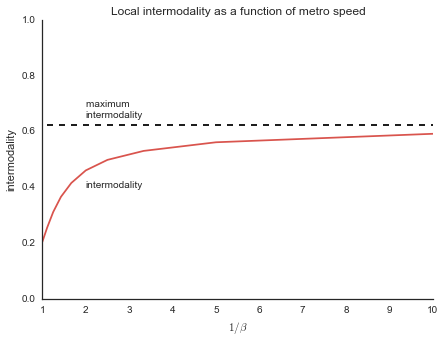

In [23]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
plt.plot(1 / sub_betas, inter, color = sns.xkcd_rgb["pale red"])
plt.text(2, .4, 'intermodality')

plt.plot([inter.max() for beta in sub_betas], color = 'black', ls = '--')
plt.text(2, .65, 'maximum \nintermodality')

ax.set(xlim = (1, 10), ylim = (0,1), xlabel = r'$1/\beta$', ylabel = 'intermodality', 
       title = 'Local intermodality as a function of metro speed')
sns.despine()
plt.savefig('4_figs/shortest_paths/intermodality.png')

### Observations

1. Under our assumptions, approximately 20% of shortest paths pass through the metro system, even without any scaling. However, as we've seen above, the reduction in travel time is very slight. 
2. There is an upper bound on intermodality of approximately 60%. This suggests that roughly 40% of people would spend more time traveling on congested streets to and from the metro than they would driving directly to their destination. 

# 3. Wrapping Up

In our investigation of shortest path lengths, we have learned the following: 

1. Under uniform demand, Riyadh's shortest path distributions are comparable to those found in Strano et al. These distributions are approximately invariant under changes in edge weights up to scale and location parameters. 
2. However, under realistic OD-demand, the distributions change both quantitatively and qualitatively, and are now sensitive to changes in edge weights. 
3. Predictably, origin and destination demand are distributed differently around the city. At this high level we can still observe some interesting commuting trends, including long-distance commutes from the outskirts, flows into downtown and very short flows for those who live closer to work.
4. The introduction of a metro at planned speed does not significantly change the character of shortest path distributions under uniform or OD demand. However, significantly increasing the metro speed as in Strano et al. leads to interesting behavior, including the existence of limiting distributions in both cases. 
5. Intermodality models metro utilization. We observe substantial intermodality even at $\beta = 1$, suggesting that over 20% of people find (small) time-savings by taking the metro. However, there is an upper limit; regardless of metro speed, almost 40% of trips are more direct via driving, regardless of metro speed.  